In [1]:
# Importando pacotes
import numpy as np
import pandas as pd
from sklearn import preprocessing
import math

In [2]:
# Leitura da base
dados= pd.read_csv (r'base_pocos.csv',index_col=0,skiprows=1,
                   names=['IND','NOME','FASE','TIPO','LDA','DIAMETRO','METRAGEM','NFASES'])

In [3]:
# Convertendo a coluna DIAMETRO de polegadas para metro

dados['DIAMETRO']=dados['DIAMETRO'].str.strip()
dados[["DIAM1", "DIAM2"]] = dados["DIAMETRO"].str.split(pat=" ", expand=True)
dados[["DIAM3", "DIAM4"]] = dados["DIAM2"].str.split(pat="/", expand=True)
dados['DIAM3'].fillna(value='0', inplace = True)
dados['DIAM4'].fillna(value='1', inplace = True)
dados['DIAM1'] = dados.DIAM1.astype(int)
dados['DIAM3'] = dados.DIAM3.astype(int)
dados['DIAM4'] = dados.DIAM4.astype(int)
dados['DIAM5'] = dados[['DIAM3']].div(dados['DIAM4'].values,axis=0)
dados['DIAMETRO'] = dados[['DIAM1','DIAM5']].sum(axis=1)
dados['DIAMETRO']=dados['DIAMETRO']*.254
dados=dados.drop(['DIAM1', 'DIAM2','DIAM3','DIAM4','DIAM5'], axis=1)

In [4]:
# Data Engineering - Pegando medidas resumo e calculando o Volume
dados['VOLUME']=(dados['DIAMETRO']*0.5)**2*math.pi*dados['METRAGEM']

dados_soma=dados.groupby(['NOME']).sum()
dados_soma['DIAMETRO_POND']=dados_soma['VOLUME']/dados_soma['METRAGEM']
dados_soma=dados_soma[['METRAGEM','VOLUME','DIAMETRO_POND']]
dados_soma.rename(columns={'METRAGEM': 'METRAGEM_TOTAL','VOLUME':'VOLUME_TOTAL'}, inplace=True)


dados_media=dados.groupby(['NOME']).mean()
dados_media=dados_media[['DIAMETRO','METRAGEM','VOLUME']]
dados_media.rename(columns={'METRAGEM': 'METRAGEM_MEDIA','VOLUME':'VOLUME_MEDIO','DIAMETRO':'DIAMETRO_MEDIO'}, inplace=True)

dados_std=dados.groupby(['NOME']).std()
dados_std=dados_std[['DIAMETRO','METRAGEM','VOLUME']]
dados_std.rename(columns={'METRAGEM': 'METRAGEM_STD','VOLUME':'VOLUME_STD','DIAMETRO':'DIAMETRO_STD'}, inplace=True)


dados_min=dados.groupby(['NOME']).min()
dados_min=dados_min[['DIAMETRO','METRAGEM','VOLUME']]
dados_min.rename(columns={'METRAGEM': 'METRAGEM_MIN','VOLUME':'VOLUME_MIN','DIAMETRO':'DIAMETRO_MIN'}, inplace=True)


dados_max=dados.groupby(['NOME']).max()
dados_max=dados_max[['DIAMETRO','METRAGEM','VOLUME']]
dados_max.rename(columns={'METRAGEM': 'METRAGEM_MAX','VOLUME':'VOLUME_MAX','DIAMETRO':'DIAMETRO_MAX'}, inplace=True)


#dados_range=dados_max['DIAMETRO_MAX']-dados_min['DIAMETRO_MIN']

In [5]:
#Data Engineering - Pegando o formato dos poços. 
#Exemplo: Um poço de 3 fases cujo diâmetro diminui a cada fase é um poço com formato '321'. Se o poço de 3 fases  aumenta 
#seu diâmetro a cada fase, é um poço de formato '123'.

dados2=dados.set_index('NOME')
formato2=[]
for nome in dados2.index.unique():
    if dados2.loc[nome]['NFASES'].sum()>1:
        formato=(1+np.argsort(dados2.loc[nome]['DIAMETRO'].values)).astype(str)
        formato=''.join(formato)
        formato2.append(formato)
        #print(formato)
    else:
        formato='1'
        #print(formato)
        formato2.append(formato)
formato_poco=pd.DataFrame(formato2,dados2.index.unique(),columns=['FORMATO'])
#formato_poco.reset_index()

In [6]:
# Fazendo o JOIN para criar o dataset final
df=dados_soma.join(dados_media)
df=df.join(dados_std)
df=df.join(dados_min)
df=df.join(dados_max)
df['DIAMETRO_RANGE']=df['DIAMETRO_MAX']-df['DIAMETRO_MIN']
df['VOLUME_RANGE']=df['VOLUME_MAX']-df['VOLUME_MIN']
df['METRAGEM_RANGE']=df['METRAGEM_MAX']-df['METRAGEM_MIN']

dados3=dados[['NOME','TIPO','LDA','NFASES']].set_index('NOME')
dados3.reset_index(inplace=True)
dados3.drop_duplicates(inplace=True)
dados3.set_index('NOME',inplace=True)

df=df.join(dados3)

df=df.join(formato_poco)

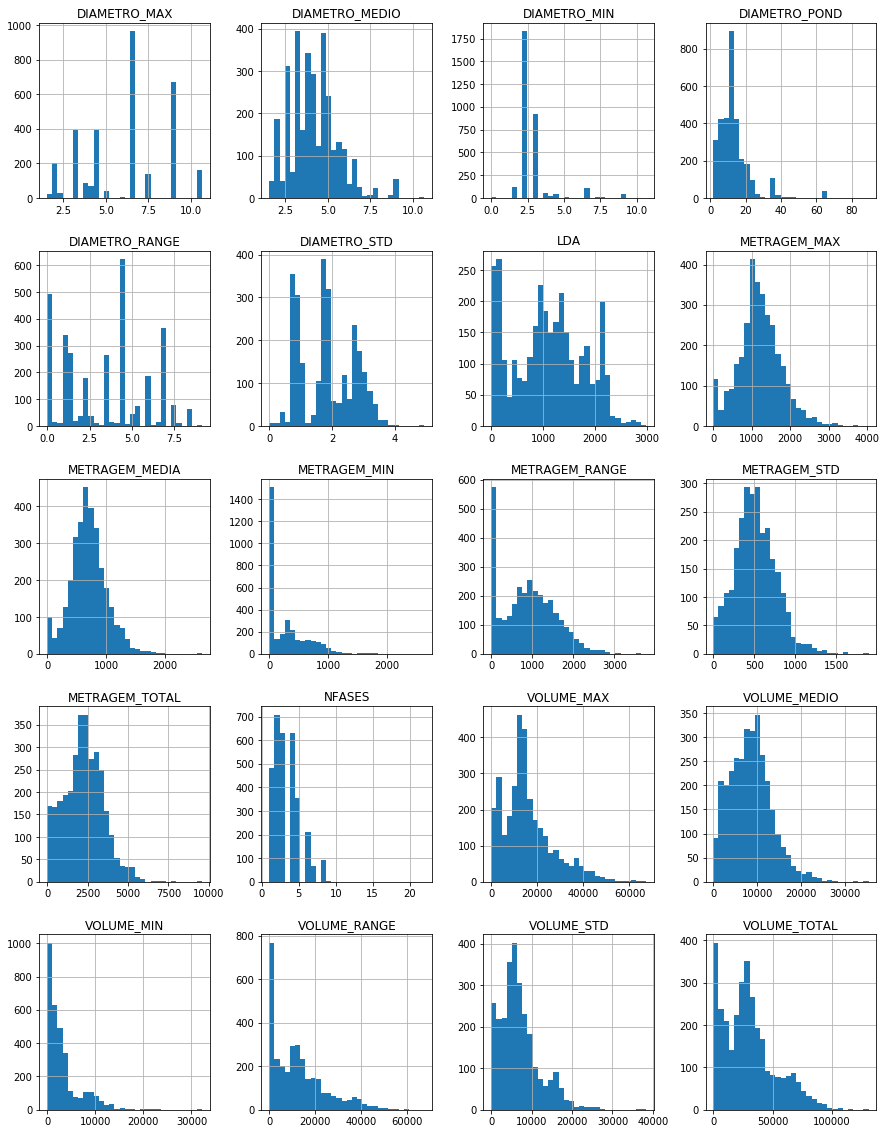

In [8]:
#Análise exploratória
hist = df.hist(bins=30,figsize=(15,20))

In [9]:
df.head()

,METRAGEM_TOTAL,VOLUME_TOTAL,DIAMETRO_POND,DIAMETRO_MEDIO,METRAGEM_MEDIA,VOLUME_MEDIO,DIAMETRO_STD,METRAGEM_STD,VOLUME_STD,DIAMETRO_MIN,...,DIAMETRO_MAX,METRAGEM_MAX,VOLUME_MAX,DIAMETRO_RANGE,VOLUME_RANGE,METRAGEM_RANGE,TIPO,LDA,NFASES,FORMATO
NOME,,,,,,,,,,,,,,,,,,,,,
001L7P,3927.0,80260.608873,20.438148,4.76250,654.5,13376.768145,2.642699,646.354315,18338.111863,2.1590,...,9.1440,1533.0,46379.138245,6.9850,46379.138245,1533.0,VERTICAL,2140.0,6,546321
004E6L,1983.0,15078.293972,7.603779,3.11150,1983.0,15078.293972,NaN,NaN,NaN,3.1115,...,3.1115,1983.0,15078.293972,0.0000,0.000000,0.0,HORIZONTAL,1034.0,1,1
0056I8,1118.0,19856.599337,17.760822,6.79450,559.0,9928.299669,3.322695,719.834703,9397.216065,4.4450,...,9.1440,1068.0,16573.134873,4.6990,13289.670408,1018.0,VERTICAL,1195.0,2,21
0089FG,1841.0,23952.870102,13.010793,4.09575,920.5,11976.435051,1.391940,190.211724,5592.434123,3.1115,...,5.0800,1055.0,15930.883143,1.9685,7908.896184,269.0,DIRECIONAL,1723.0,2,12
00DL2O,1078.0,3946.516536,3.660962,2.15900,1078.0,3946.516536,NaN,NaN,NaN,2.1590,...,2.1590,1078.0,3946.516536,0.0000,0.000000,0.0,HORIZONTAL,1315.0,1,1


In [10]:
#Um poço possui 22 fases. É possível que seja um erro de digitação e o correto sejam 2 fases
#Alguns poços possuem TIPO == 0. Nesse caso,se for um erro, não é possível definir um valor para correção

df.NFASES.value_counts()
df["NFASES"].replace({22: 2}, inplace=True)

In [33]:
#Salvando a base preparada par aanálise

# O Desvio padrão dos poços com apenas uma fase são NaN. Para o tipo de análise que faremos, podemos
#substituir esses NaN por 0.

df.fillna(0,inplace = True)
df.to_csv('base_final.csv')